In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.distributions as dist
import torchvision.models as models


import os

from datasets import NoisyCUB200
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
dataset = 'cub200'
n_cls = 200
net_type = 'resnet'
noise_type = 'symmetric'#'pairflip' #'symmetric'
noise_rate = 0#0.45 #0.5
checkpoint_path = "../results/%s/intranoisyset/baseline/pretrained/%s/%s/noise_rate_%.2f/seed_0/checkpoint.pth.tar" % (dataset, net_type, noise_type, noise_rate)

In [3]:
n_ex_per_cls = [0] * n_cls
cls_feats = None

In [4]:
if dataset == 'cub200':
    trainset= NoisyCUB200(root='../data/'+dataset, year=2011, train=True, noise_rate=noise_rate)
elif dataset == 'sop':
    trainset = datasets.StanfordOnlineProduct(root='../data/'+dataset, train=True)
print('Training set size:', len(trainset))

Training set size: 3000


In [5]:
if net_type == 'resnet':
    model = models.resnet50()
    model.fc = nn.Linear(model.fc.in_features, n_cls)
elif net_type == 'densenet':
    model = models.densenet161()
    model.classifier = nn.Linear(model.classifier.in_features, n_cls // num_splits)

In [6]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

# partitioning generation

In [7]:
# settings
n_parts = 2
n_cls_per_part_threshold = 10

pool_size = 1000

save_path = '../data/%s_intranoisy_partitions/%s/%s/noise_rate_%.2f' % (dataset, net_type, noise_type, noise_rate)

In [8]:
seed=0

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [9]:
if net_type == 'resnet':
    cls_feats = model.fc.weight.data.cpu().numpy()
elif net_type == 'densenet':
    cls_feats = model.classifier.weight.data.cpu().numpy()

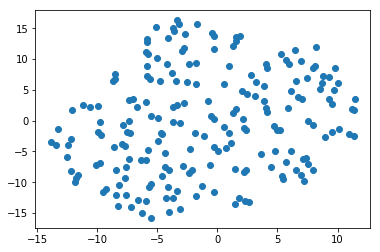

In [10]:
cls_reduced_feats = TSNE(learning_rate=100, metric='cosine').fit_transform(cls_feats)
plt.scatter(cls_reduced_feats[:, 0], cls_reduced_feats[:, 1])
plt.show()

In [11]:
clusters = []
kmeans = KMeans(n_clusters=n_parts, n_init=1, init='random')
for i in range(pool_size):
    if (i+1) % 500 == 0:
        print(i+1)
    kmeans.fit(cls_feats[:, np.random.permutation(2048)[:50]])
    clusters.append(kmeans.labels_)

if not os.path.isdir(save_path):
    os.makedirs(save_path)
partitions = torch.from_numpy(np.stack(clusters)).long()
torch.save(partitions, os.path.join(save_path, 'part_%d_kmeans.pth.tar' % n_parts))

500
1000
